## CNN on Google Speech Command Dataset & Custom Dataset

1. Here we are just going to implement a  CNN Model on our custom wake word dataset, where the wakeword 'fourtbrain' is recorded over 100 times and similary other wake word of background nosie is recorded for 100 times and stored.

#### 1. Usual Imports 

Here we are going to import the necessary files which are essential for preprocessing the wav files (librosa) and sklearn library for MLP Classifier, train test split, classification report

In [54]:

import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import layers, models


import librosa
import librosa.display
import python_speech_features


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
warnings.filterwarnings("ignore")
np.random.seed(12345)

#### 2. Data Aggregation

We are going to label the folder with wake_words as 1 and other_words as 0, 
We will use the os.listdir to reach the directory, extract the file_path for each .wav file and then make dictionary with 0 and 1 for each of the file path

In [5]:
data_path_dict = {
    0: ["dat/other_words/" + file_path for file_path in os.listdir("dat/other_words/")],
    1: ["dat/wake_word/" + file_path for file_path in os.listdir("dat/wake_word/")]
}
data_path_dict.items()

dict_items([(0, ['other_words/16.wav', 'other_words/17.wav', 'other_words/15.wav', 'other_words/29.wav', 'other_words/28.wav', 'other_words/14.wav', 'other_words/38.wav', 'other_words/10.wav', 'other_words/11.wav', 'other_words/39.wav', 'other_words/13.wav', 'other_words/12.wav', 'other_words/61.wav', 'other_words/75.wav', 'other_words/49.wav', 'other_words/48.wav', 'other_words/74.wav', 'other_words/60.wav', 'other_words/76.wav', 'other_words/62.wav', 'other_words/89.wav', 'other_words/88.wav', 'other_words/63.wav', 'other_words/77.wav', 'other_words/9.wav', 'other_words/73.wav', 'other_words/67.wav', 'other_words/98.wav', 'other_words/99.wav', 'other_words/66.wav', 'other_words/72.wav', 'other_words/8.wav', 'other_words/58.wav', 'other_words/64.wav', 'other_words/70.wav', 'other_words/71.wav', 'other_words/65.wav', 'other_words/59.wav', 'other_words/40.wav', 'other_words/54.wav', 'other_words/6.wav', 'other_words/68.wav', 'other_words/83.wav', 'other_words/97.wav', 'other_words/96.wa

#### 2.1 Appending all the data

Here we will just append the file path and label in one list, so the output will be like that for each.wav file there will be label which we have assigned based on whether it is a wake word or not


In [6]:
all_data = []
for class_label, list_of_files in data_path_dict.items():
    for single_file in list_of_files:
        all_data.append([single_file, class_label])
print("The type of all_data is : " , type(all_data))
print("Sample for peek and seek guidance : ", all_data[1])

The type of all_data is :  <class 'list'>
Sample for peek and seek guidance :  ['other_words/17.wav', 0]


#### 2.2 Splitting - Trainset and Testset

Since we have very limited dataset of recording, we will be just going with train and test split, not focussing on validation set. The split is 30 % for testset. Let's see how it performs with this limited data

Using the sklearn.model_selection import train_test_split

In [7]:
# Split the dataset into train and test dataset
trainset, testset = train_test_split(all_data, test_size=0.30, random_state=100)
print("The type of train and test is : ", type(trainset), " and ",type(testset))
print("The size as per specified split :", len(trainset), " and ", len(testset))

The type of train and test is :  <class 'list'>  and  <class 'list'>
The size as per specified split : 140  and  60


#### 3. Exploration of Custom audio dataset

Here we are going to explore some of the features which we can get from the librosa library - waveshow, spectral centroid and spectogram. We will jsut loook for one of the file

#### 3.1 Waveshow, Spectogram

The ouput is collapsed, run the cell again to check, However this is optional, just to understand the how the amplitude varies with time, and how we can filter based on the time or sample rate to get features

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'wake_word')

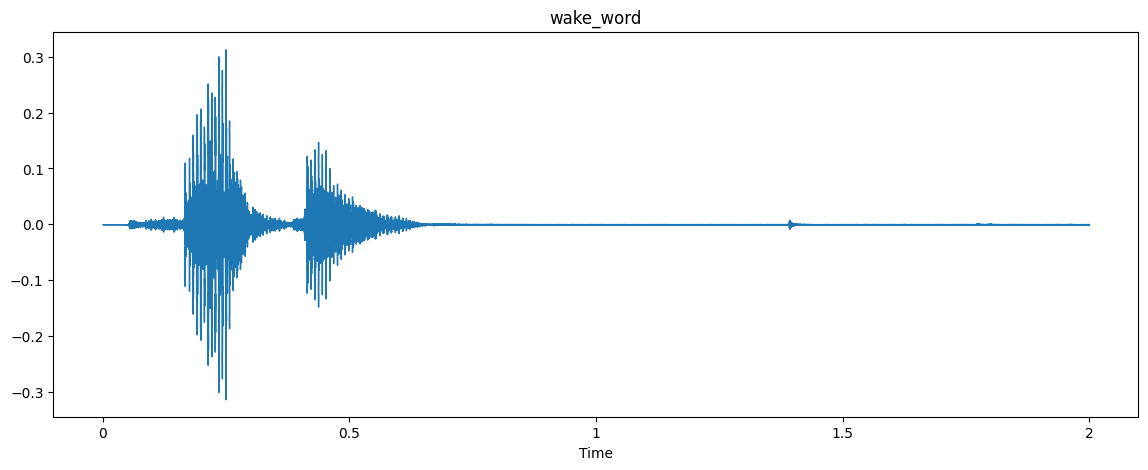

In [8]:
%matplotlib inline

rand_i = np.random.randint(20)
x , sr = librosa.load(trainset[rand_i][0])
plt.figure(figsize=(14,5))
librosa.display.waveshow(x, sr=sr)
if 'other_words' in trainset[rand_i][0]:
    title = 'other_words'
else:
    title = 'wake_word'
plt.title(title)

Text(0.5, 1.0, 'wake_word')

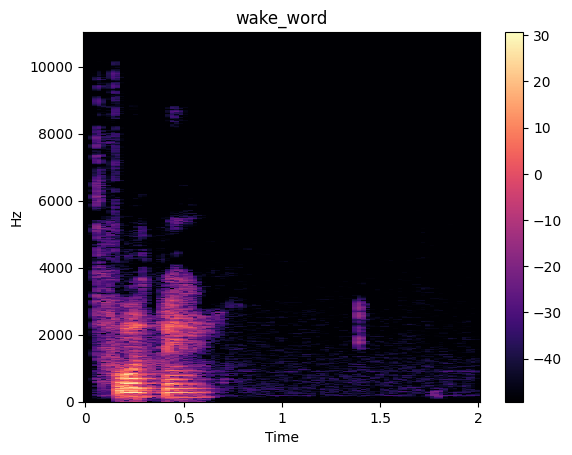

In [9]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
if 'other_words' in trainset[rand_i][0]:
    title = 'other_words'
else:
    title = 'wake_word'
plt.title(title)
plt.colorbar()

#### 3.2 Let's explore some features that we can extract from audio wave files

1. RMS - RMS is used to characterize the “average” of continuous varying signals such as audio, electrical signals, sound, etc. In audio waveforms, these maximum is often called “peak” signal and often measured in dB in digital. Between the minimum (the quietest sections of the audio) and the loudest section (towards 0dBFS, the peak) is where the RMS value can be found. 

2. In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.[1] They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum")

3. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale

4. The zero-crossing rate (ZCR) is the rate at which a signal transitions from positive to zero to negative or negative to zero to positive. Its value has been extensively used in both speech recognition and music information retrieval for classifying percussive sounds. 
https://www.analyticsvidhya.com/blog/2022/01/analysis-of-zero-crossing-rates-of-different-music-genre-tracks/#:~:text=Zero%2DCrossing%20Rate%3A%20The%20zero,retrieval%20for%20classifying%20percussive%20sounds.

Other features - https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/

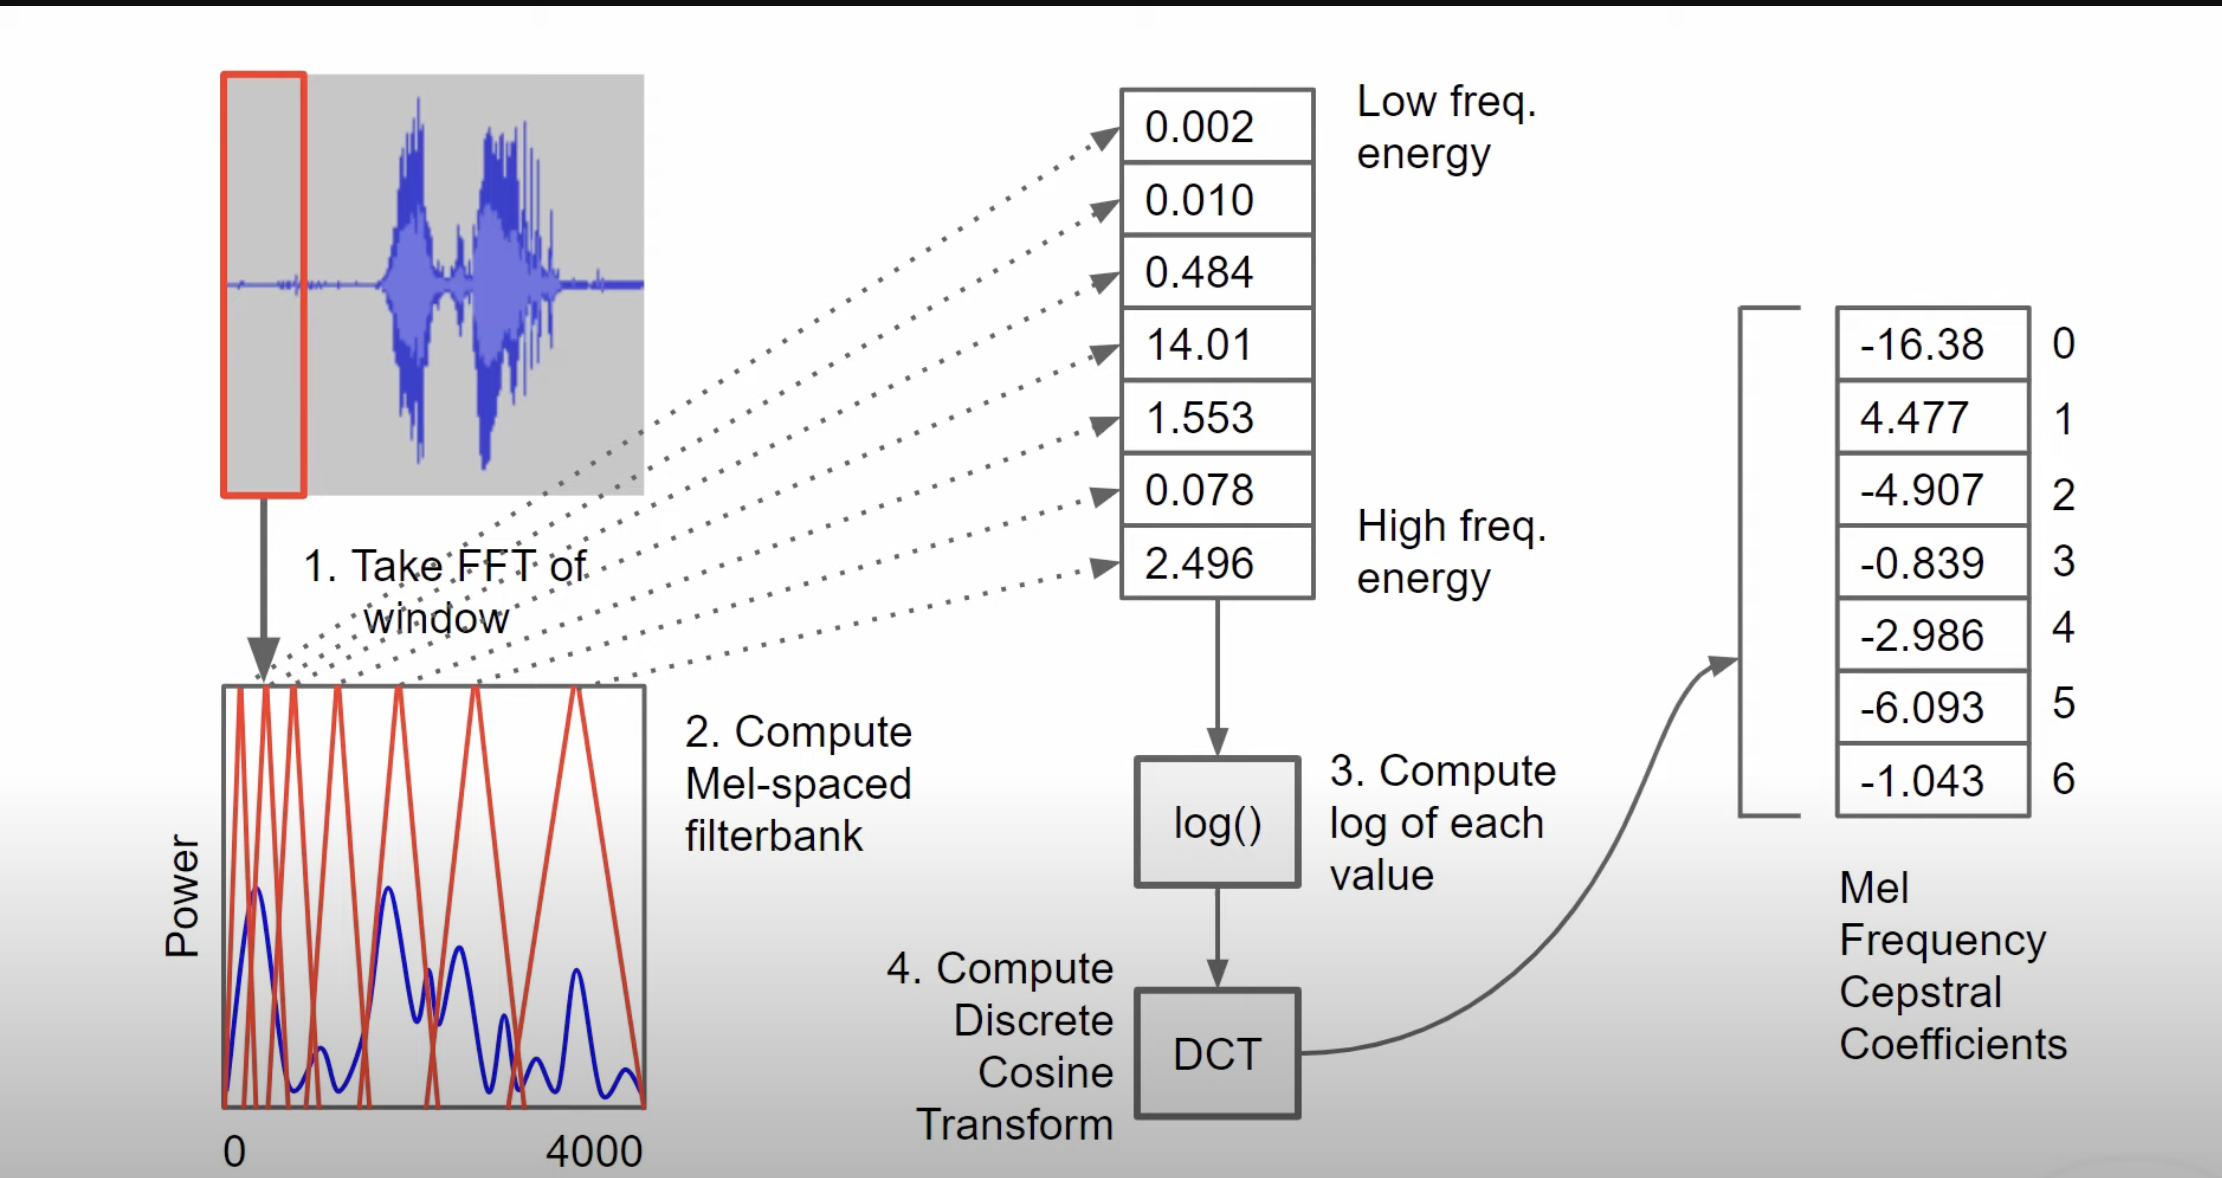

Image spurce from tutorials


In [10]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../wakeword-spotify/imgs/MFCC-Part1.png'
display(Image(filename=filename))
print("Image spurce from tutorials")

In [11]:
x, sr = librosa.load(trainset[rand_i][0])
mfcc = librosa.feature.mfcc(y=x, sr=sr)
print("The shape of the feature :", mfcc.shape," and the mean value" ,np.mean(mfcc))

rmse = librosa.feature.rms(y=x)
print("The shape of the feature RMS :", rmse.shape," and the mean value", np.mean(rmse))

chroma_stft = librosa.feature.chroma_stft(y=x, sr=sr)
print("The shape of the feature chroma short term fourier transform:", chroma_stft.shape, 
      " and the mean value", np.mean(chroma_stft))

spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=sr)
print("The shape of the feature spectral bandwidt :", spec_bw.shape," and the mean value", np.mean(spec_bw))

zcr = librosa.feature.zero_crossing_rate(x)
print("The shape of the feature Zero Crossing Rate:", zcr.shape," and the mean value", np.mean(zcr))


The shape of the feature : (20, 87)  and the mean value -29.860565
The shape of the feature RMS : (1, 87)  and the mean value 0.008076858
The shape of the feature chroma short term fourier transform: (12, 87)  and the mean value 0.5138383
The shape of the feature spectral bandwidt : (1, 87)  and the mean value 1937.7117088449843
The shape of the feature Zero Crossing Rate: (1, 87)  and the mean value 0.12964709051724138


#### 4. Function for feature extraction

There are some features in aduio files which we want to capture and use in training the model. The spme of them found out from google are rmse, chroma_stft, spec_ce, mfcc, rolloff

We will take the mean of each features and store in an empty dictionary

In [19]:
def features(df):

    feature_dict = { 'mfcc_processed':[],'label':[]}
 
    for i in tqdm(range(df.shape[0])):
     
        x , sr = librosa.load(df.iloc[i][0])
        mfcc = python_speech_features.base.mfcc(x, 
                                            samplerate=sr,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=16,
                                            nfilt=26,
                                            nfft=8192,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)

        target = df.iloc[i]['label']

        # Here we will take mean     
        feature_dict['mfcc_processed'].append(mfcc.T)
        feature_dict['label'].append(target)
 
    return feature_dict

#### 5. Let's implement the features function to our trainset and testset

Let's first connvert the trainset which is list to a dataframe and finally store the features in df_train and df_test

In [49]:
trainset_df = pd.DataFrame(trainset, columns=['name','label'])
temp = features(trainset_df)
df_train = pd.DataFrame(temp)

testset_df = pd.DataFrame(testset, columns=['name','label'])
temp = features(testset_df)
df_test = pd.DataFrame(temp)


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

#### 6. Seprate the labels and features

Simply remove the column label from both the df_train and df_test and store the features in X_train and X_test, while labels in y_train, and y_test

In [52]:
X_train = df_train['mfcc_processed'].values
X_train = np.concatenate(X_train, axis=0).reshape(len(X_train), 16, 36)
y_train = np.array(df_train['label'])

X_test = df_test['mfcc_processed'].values
X_test = np.concatenate(X_test, axis=0).reshape(len(X_test), 16, 36)
y_test = np.array(df_test['label'])
print("let's print the shape of features and labels of training set ", X_train.shape, y_train.shape)
print("let's print the shape of features and labels of test set ", X_test.shape, y_test.shape)

let's print the shape of features and labels of training set  (140, 16, 36) (140,)
let's print the shape of features and labels of test set  (60, 16, 36) (60,)


In [66]:
np.savez('../wakeword-tensorflow/features/features_cnn.npz', 
         X_train=X_train, 
         y_train=y_train, 
         X_test=X_test, 
         y_test=y_test)

#### 7. Data Reshaping 

CNN for TF expects (batch, height, width, channels), So we reshape the input tensors with a "color" channel of 1


In [53]:
X_train = X_train.reshape(X_train.shape[0], 
                          X_train.shape[1], 
                          X_train.shape[2], 
                          1)

X_test = X_test.reshape(X_test.shape[0], 
                        X_test.shape[1], 
                        X_test.shape[2], 
                        1)
print(X_train.shape)
print(X_test.shape)

(140, 16, 36, 1)
(60, 16, 36, 1)


#### 8. Finally - A Model - CNN

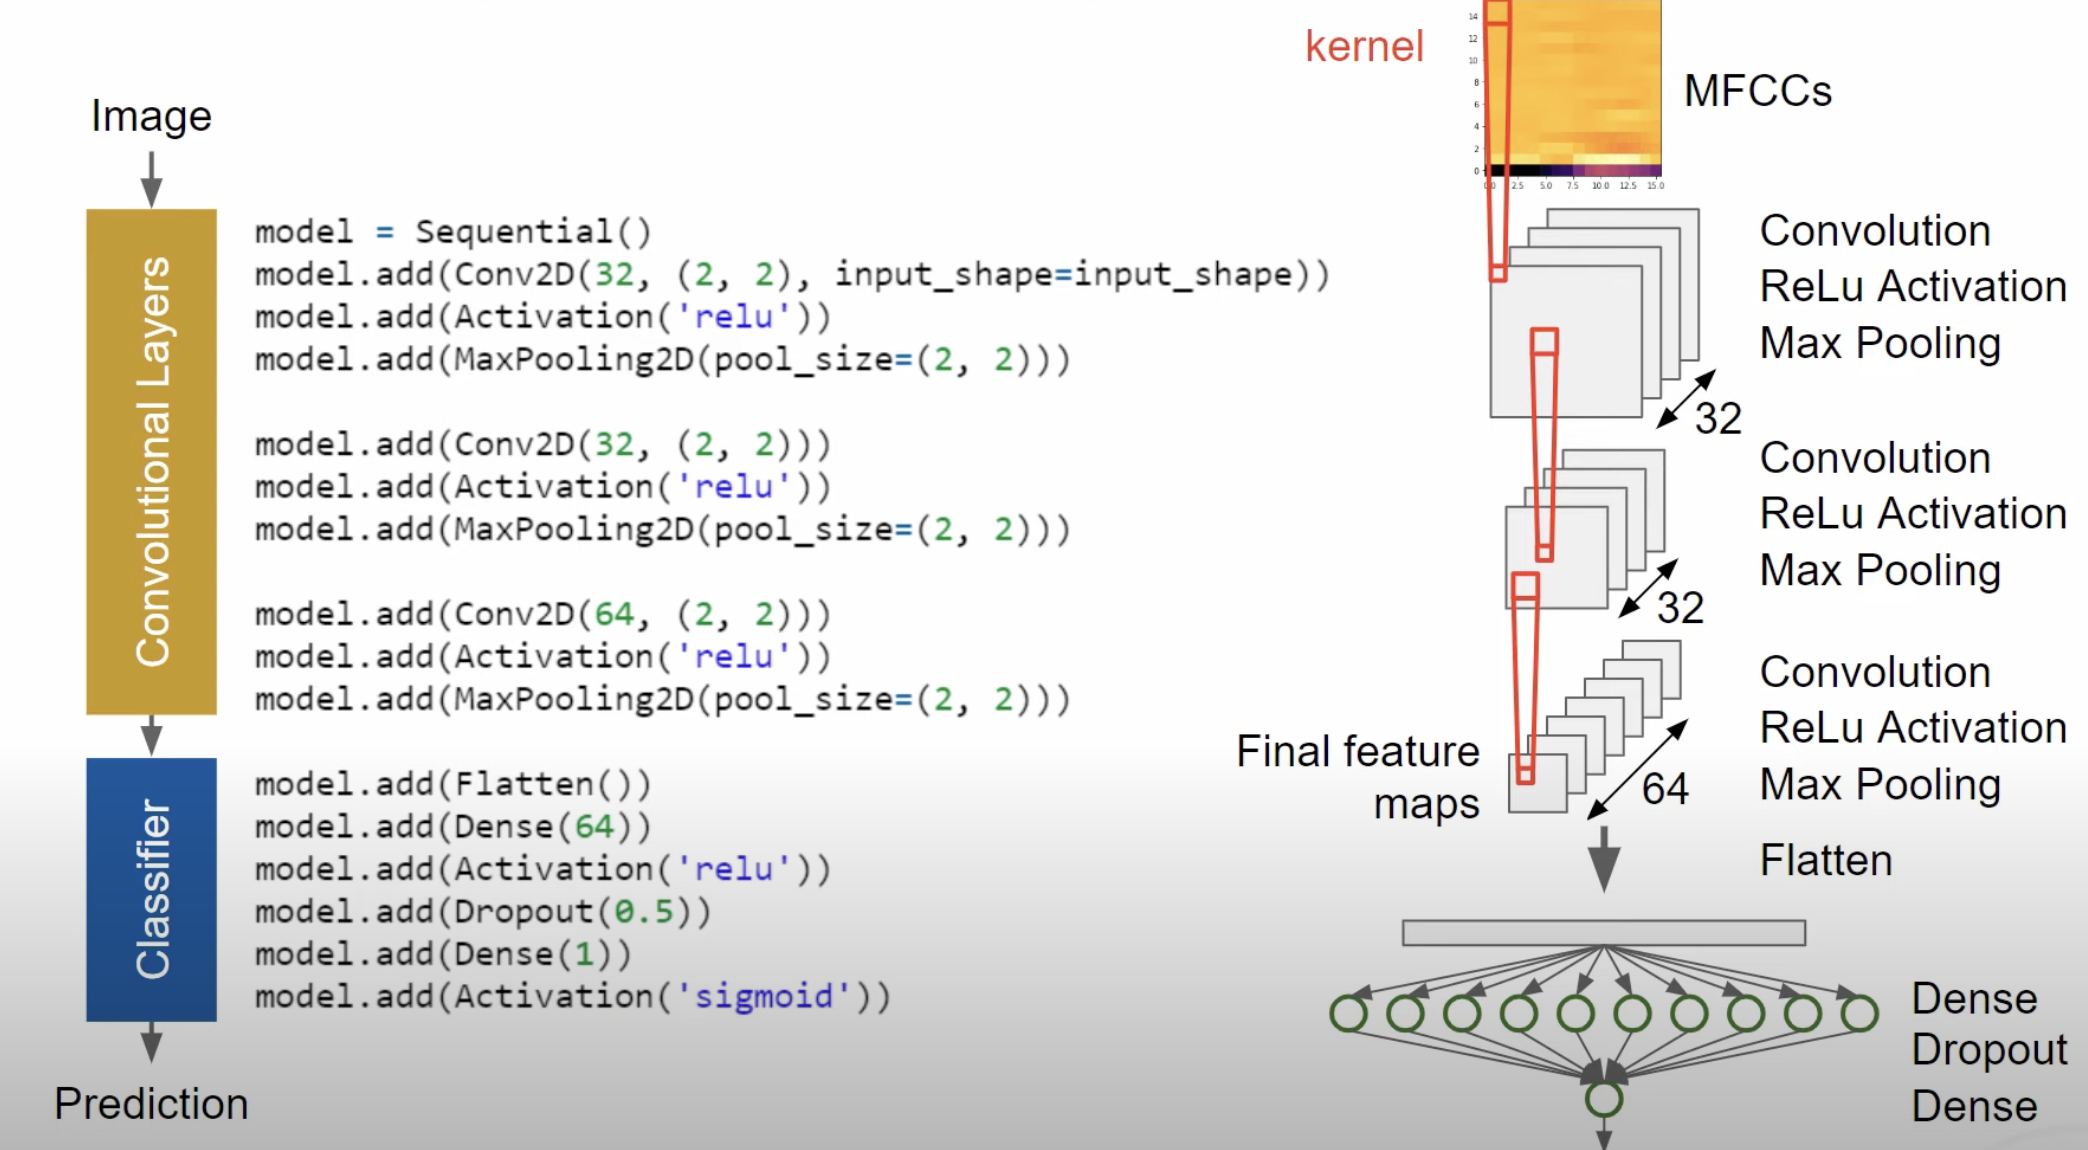

Image source from tutorials/ geeks for geeks


In [64]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../wakeword-spotify/imgs/MFCC-CNN-Part3.png'
display(Image(filename=filename))
print("Image source from tutorials/ geeks for geeks")

In [57]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = X_test.shape[1:]

# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Display model
model.summary()

# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 15, 35, 32)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 17, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 16, 32)         4128      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 7, 64)          8256      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 3, 64)        

In [60]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100,
                    )

Epoch 1/30
2/2 [==============================] - 0s 8ms/step - loss: 0.1170 - accuracy: 0.9500
Epoch 2/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1316 - accuracy: 0.9714
Epoch 3/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.9714
Epoch 4/30
2/2 [==============================] - 0s 7ms/step - loss: 0.1250 - accuracy: 0.9786
Epoch 5/30
2/2 [==============================] - 0s 8ms/step - loss: 0.1907 - accuracy: 0.9429
Epoch 6/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1229 - accuracy: 0.9571
Epoch 7/30
2/2 [==============================] - 0s 7ms/step - loss: 0.0907 - accuracy: 0.9714
Epoch 8/30
2/2 [==============================] - 0s 8ms/step - loss: 0.2567 - accuracy: 0.9000
Epoch 9/30
2/2 [==============================] - 0s 8ms/step - loss: 0.1130 - accuracy: 0.9643
Epoch 10/30
2/2 [==============================] - 0s 17ms/step - loss: 0.0883 - accuracy: 0.9643
Epoch 11/30
2/2 [==================

#### 9. Evaluate the Model

In [61]:
model.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.2982 - accuracy: 0.9167


[0.29815614223480225, 0.9166666865348816]

#### 10. Save the Model

In [65]:
model.save("saved_model/model_cnn.h5")